In [ ]:
import torch
import copy
import torchvision
import numpy as np
import random
import os
from tqdm import tqdm
from torchvision import transforms as T
from torchvision import models
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10
import torch.optim as optim
from google.colab import drive

In [ ]:
# ONLY AVAILABLE IF WORKING INSIDE GOOGLE COLAB
# IF NOT WORKING INSIDE GOOGLE COLAB, PLEASE IGNORE THIS CELL
drive.mount('/content/gdrive')
os.chdir('/content/gdrive/MyDrive/CAPSTONE/')

Mounted at /content/gdrive


In [ ]:
from IKSA_optimizers.SGD_IKSA import SGD_IKSA
from IKSA_optimizers.Adam_IKSA import Adam_IKSA

In [ ]:
!nvidia-smi -L 

GPU 0: Tesla T4 (UUID: GPU-6848b470-6a0d-2530-e9b5-28945418151a)


In [ ]:
# dir(models)
# tried previously: mobilenet_v2, vgg16
MODEL_IDENTIFIER = 'resnet110_noshort'
# previous optimizer names: SGD_IKSA, Adam_IKSA
OPTIMIZER_NAME= 'SGD_IKSA'
DATASET_NAME = 'cifar10'


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
# LOAD MODEL FROM TORCH: model = torch.hub.load('pytorch/vision:v0.6.0', MODEL_IDENTIFIER, weights = None, verbose=False)
# from cifar10_models.vgg import VGG
from cifar10_models.resnet import ResNet56_noshort
from cifar10_models.resnet import ResNet110_noshort

In [ ]:
# model = VGG()
model = ResNet110_noshort()

In [ ]:
model.to(device)

ResNet_cifar(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock_noshortcut(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock_noshortcut(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=Tru

In [ ]:
PATH_TO_DATASET = "./data"

transform_train = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_test = T.Compose([
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

dataset = CIFAR10(root='./data', 
                   train=True,
                   download=True, 
                   transform=transform_train)

testset = CIFAR10(root='./data', 
                  train=False,
                  download=True, 
                  transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
dataset_size = len(dataset)
print("Dateset Size: ", dataset_size)
classes = dataset.classes
print("Classes: ", classes[0:10])

Dateset Size:  50000
Classes:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
img, label = dataset[1]
img_shape = img.shape
img_shape

torch.Size([3, 32, 32])

Label (numeric): 6
Label (textual): frog
<class 'torch.Tensor'>
torch.Size([3, 32, 32])


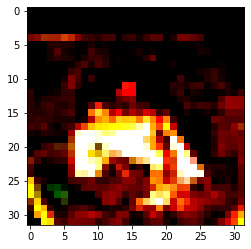

In [ ]:
img, label = dataset[0]
plt.imshow(img.permute((1, 2, 0)))
print('Label (numeric):', label)
print('Label (textual):', classes[label])
print(type(img))
print(img.size())

In [ ]:
# We set the seed at the beginning of each experiment to ensure reproducibility.
# We also make sure no non-deterministic methods are used.

def setup_seed(s):
  torch.manual_seed(s)
  random.seed(s)
  np.random.seed(s)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

In [ ]:
SEED = 1234

In [ ]:
setup_seed(SEED)

In [ ]:
# We preserve reproducibility in data loading:
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32

In [ ]:
g = torch.Generator()
g.manual_seed(SEED)

In [ ]:
BATCH_SIZE = 128
train_loader = torch.utils.data.DataLoader(dataset, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True, 
                                           num_workers=4, 
                                           worker_init_fn=seed_worker, 
                                           generator=g)

In [ ]:
# FUNCTIONS FOR IKSA OPTIMIZER
identity_function = lambda x: x
square_function = lambda x: x**2
cube_function = lambda x: x**3
arctan_x_sq_function = lambda x: torch.atan(x**2)
FNAME = "x^2"

In [ ]:
N_EPOCHS = 100
LR = 0.05 # 0.005, 0.001
MOMENTUM = 0.9
WEIGHT_DECAY = 0 # previously 0.0005
LM_c = 1
LM_c_run_min = False
EPS_IAKSA = 1
BETAS = (0.9, 0.999) # default beta values for the Adam Optimizer
# different values of c: 2, 1, adaptive
# --------------------------------------------
criterion = torch.nn.CrossEntropyLoss()
# choose different optimizers: RMSProp, Adam
optimizer = SGD_IKSA(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY, function=square_function, eps_IAKSA=EPS_IAKSA)
# optimizer = Adam_IKSA(model.parameters(), lr=LR, betas=BETAS, weight_decay=WEIGHT_DECAY, function=square_function, eps=EPS_IAKSA)

In [ ]:
if not LM_c_run_min:
  SAVED_MODEL_NAME = f'{DATASET_NAME}_{MODEL_IDENTIFIER}_{OPTIMIZER_NAME}_epochs={N_EPOCHS}_BS={BATCH_SIZE}_SEED={SEED}_LR={LR}_MOM={MOMENTUM}_WD={WEIGHT_DECAY}_C={LM_c}_f={FNAME}.pt'
  #SAVED_MODEL_NAME = f'{DATASET_NAME}_{MODEL_IDENTIFIER}_{OPTIMIZER_NAME}_epochs={N_EPOCHS}_BS={BATCH_SIZE}_SEED={SEED}_LR={LR}_BETA1={BETAS[0]}_BETA2={BETAS[1]}_WD={WEIGHT_DECAY}_C={LM_c}_f={FNAME}.pt'
else:
  SAVED_MODEL_NAME = f'{DATASET_NAME}_{MODEL_IDENTIFIER}_{OPTIMIZER_NAME}_epochs={N_EPOCHS}_BS={BATCH_SIZE}_SEED={SEED}_LR={LR}_MOM={MOMENTUM}_WD={WEIGHT_DECAY}_C=adaptive_f={FNAME}.pt'
  #SAVED_MODEL_NAME = f'{DATASET_NAME}_{MODEL_IDENTIFIER}_{OPTIMIZER_NAME}_epochs={N_EPOCHS}_BS={BATCH_SIZE}_SEED={SEED}_LR={LR}_BETA1={BETAS[0]}_BETA2={BETAS[1]}_WD={WEIGHT_DECAY}_C=adaptive_f={FNAME}.pt'
print(SAVED_MODEL_NAME)

cifar10_resnet110_noshort_SGD_IKSA_epochs=100_BS=128_SEED=1234_LR=0.05_MOM=0.9_WD=0_C=1_f=x^2.pt


In [ ]:
if not LM_c_run_min:
  PARTIAL_NAME = f'{DATASET_NAME}_{MODEL_IDENTIFIER}_{OPTIMIZER_NAME}_epochs={N_EPOCHS}_BS={BATCH_SIZE}_SEED={SEED}_LR={LR}_MOM={MOMENTUM}_WD={WEIGHT_DECAY}_C={LM_c}_f={FNAME}'
  #PARTIAL_NAME = f'{DATASET_NAME}_{MODEL_IDENTIFIER}_{OPTIMIZER_NAME}_epochs={N_EPOCHS}_BS={BATCH_SIZE}_SEED={SEED}_LR={LR}_BETA1={BETAS[0]}_BETA2={BETAS[1]}_WD={WEIGHT_DECAY}_C={LM_c}_f={FNAME}'
else:
  PARTIAL_NAME = f'{DATASET_NAME}_{MODEL_IDENTIFIER}_{OPTIMIZER_NAME}_epochs={N_EPOCHS}_BS={BATCH_SIZE}_SEED={SEED}_LR={LR}_MOM={MOMENTUM}_WD={WEIGHT_DECAY}_C=adaptive_f={FNAME}'
  #PARTIAL_NAME = f'{DATASET_NAME}_{MODEL_IDENTIFIER}_{OPTIMIZER_NAME}_epochs={N_EPOCHS}_BS={BATCH_SIZE}_SEED={SEED}_LR={LR}_BETA1={BETAS[0]}_BETA2={BETAS[1]}_WD={WEIGHT_DECAY}_C=adaptive_f={FNAME}'
print(PARTIAL_NAME)

cifar10_resnet110_noshort_SGD_IKSA_epochs=100_BS=128_SEED=1234_LR=0.05_MOM=0.9_WD=0_C=1_f=x^2


In [ ]:
# TRAINING THE DEEP LEARNING MODEL
train_losses, accuracies = [], []
for epoch in range(N_EPOCHS):
  running_loss = 0
  correct = 0
  total = 0
  for inputs, labels in tqdm(train_loader):
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    correct += (predicted == labels).sum().item()
    total += labels.size(0)
    loss = criterion(outputs, labels)
    loss.backward()
    # ADAPTIVE
    if LM_c_run_min:
      if loss < LM_c:
        LM_c = loss.item()
    optimizer.step(LM_c, loss)
    running_loss += loss.item()
  
  train_loss = running_loss / len(train_loader)
  train_losses.append(train_loss)
  accuracy = 100 * correct / total
  accuracies.append(accuracy)
  print(f'Train Loss : {train_loss} ;   Accuracy : {accuracy}%')

torch.save(model, SAVED_MODEL_NAME)

100%|██████████| 391/391 [01:15<00:00,  5.18it/s]


Train Loss : 2.3041213723399756 ;   Accuracy : 10.382%


100%|██████████| 391/391 [01:10<00:00,  5.58it/s]


Train Loss : 2.301760017414532 ;   Accuracy : 10.028%


100%|██████████| 391/391 [01:09<00:00,  5.62it/s]


Train Loss : 2.3009906144398253 ;   Accuracy : 9.996%


100%|██████████| 391/391 [01:09<00:00,  5.66it/s]


Train Loss : 2.301351626510815 ;   Accuracy : 10.118%


100%|██████████| 391/391 [01:09<00:00,  5.66it/s]


Train Loss : 2.301460585630763 ;   Accuracy : 10.084%


100%|██████████| 391/391 [01:09<00:00,  5.64it/s]


Train Loss : 2.3009463143165765 ;   Accuracy : 10.154%


100%|██████████| 391/391 [01:08<00:00,  5.67it/s]


Train Loss : 2.300723912465908 ;   Accuracy : 10.124%


100%|██████████| 391/391 [01:08<00:00,  5.67it/s]


Train Loss : 2.3007577124154173 ;   Accuracy : 10.318%


100%|██████████| 391/391 [01:09<00:00,  5.62it/s]


Train Loss : 2.300939695304617 ;   Accuracy : 9.988%


100%|██████████| 391/391 [01:09<00:00,  5.64it/s]


Train Loss : 2.300759265489895 ;   Accuracy : 10.036%


100%|██████████| 391/391 [01:09<00:00,  5.63it/s]


Train Loss : 2.300781005483759 ;   Accuracy : 10.082%


100%|██████████| 391/391 [01:09<00:00,  5.63it/s]


Train Loss : 2.300919416310537 ;   Accuracy : 10.056%


100%|██████████| 391/391 [01:09<00:00,  5.62it/s]


Train Loss : 2.300530019013778 ;   Accuracy : 10.264%


100%|██████████| 391/391 [01:09<00:00,  5.60it/s]


Train Loss : 2.300251022933999 ;   Accuracy : 10.15%


100%|██████████| 391/391 [01:09<00:00,  5.61it/s]


Train Loss : 2.3009816234373983 ;   Accuracy : 10.096%


100%|██████████| 391/391 [01:09<00:00,  5.60it/s]


Train Loss : 2.3003176472071187 ;   Accuracy : 10.288%


100%|██████████| 391/391 [01:09<00:00,  5.61it/s]


Train Loss : 2.3002010775953914 ;   Accuracy : 10.054%


100%|██████████| 391/391 [01:09<00:00,  5.60it/s]


Train Loss : 2.3004921781437475 ;   Accuracy : 10.086%


100%|██████████| 391/391 [01:10<00:00,  5.58it/s]


Train Loss : 2.3005566286004107 ;   Accuracy : 10.194%


100%|██████████| 391/391 [01:10<00:00,  5.57it/s]


Train Loss : 2.3002287823220957 ;   Accuracy : 10.186%


100%|██████████| 391/391 [01:09<00:00,  5.59it/s]


Train Loss : 2.3001927445306802 ;   Accuracy : 10.142%


100%|██████████| 391/391 [01:09<00:00,  5.60it/s]


Train Loss : 2.300239021515907 ;   Accuracy : 10.142%


100%|██████████| 391/391 [01:09<00:00,  5.59it/s]


Train Loss : 2.299833848348359 ;   Accuracy : 10.234%


100%|██████████| 391/391 [01:09<00:00,  5.63it/s]


Train Loss : 2.2999233321460615 ;   Accuracy : 10.222%


100%|██████████| 391/391 [01:09<00:00,  5.64it/s]


Train Loss : 2.2997850707119993 ;   Accuracy : 10.134%


100%|██████████| 391/391 [01:09<00:00,  5.65it/s]


Train Loss : 2.299738434574488 ;   Accuracy : 10.3%


100%|██████████| 391/391 [01:09<00:00,  5.65it/s]


Train Loss : 2.2995060295095224 ;   Accuracy : 10.112%


100%|██████████| 391/391 [01:09<00:00,  5.66it/s]


Train Loss : 2.2996597009546615 ;   Accuracy : 10.188%


100%|██████████| 391/391 [01:09<00:00,  5.66it/s]


Train Loss : 2.2988312152950354 ;   Accuracy : 10.07%


100%|██████████| 391/391 [01:08<00:00,  5.67it/s]


Train Loss : 2.2929750037620136 ;   Accuracy : 11.036%


100%|██████████| 391/391 [01:08<00:00,  5.67it/s]


Train Loss : 2.292101388087358 ;   Accuracy : 11.01%


100%|██████████| 391/391 [01:09<00:00,  5.66it/s]


Train Loss : 2.2922908820764487 ;   Accuracy : 11.038%


100%|██████████| 391/391 [01:08<00:00,  5.67it/s]


Train Loss : 2.2898828062559944 ;   Accuracy : 11.888%


100%|██████████| 391/391 [01:08<00:00,  5.68it/s]


Train Loss : 2.2875481889680827 ;   Accuracy : 12.11%


100%|██████████| 391/391 [01:09<00:00,  5.64it/s]


Train Loss : 2.2850122909106867 ;   Accuracy : 12.31%


100%|██████████| 391/391 [01:09<00:00,  5.66it/s]


Train Loss : 2.2821894253001496 ;   Accuracy : 12.746%


100%|██████████| 391/391 [01:08<00:00,  5.67it/s]


Train Loss : 2.2808718364257032 ;   Accuracy : 12.894%


100%|██████████| 391/391 [01:09<00:00,  5.63it/s]


Train Loss : 2.280222593975799 ;   Accuracy : 13.008%


100%|██████████| 391/391 [01:09<00:00,  5.64it/s]


Train Loss : 2.279149818298457 ;   Accuracy : 12.748%


100%|██████████| 391/391 [01:08<00:00,  5.68it/s]


Train Loss : 2.2776339541920616 ;   Accuracy : 12.94%


100%|██████████| 391/391 [01:08<00:00,  5.67it/s]


Train Loss : 2.277570800098312 ;   Accuracy : 12.928%


100%|██████████| 391/391 [01:08<00:00,  5.68it/s]


Train Loss : 2.2743507858432466 ;   Accuracy : 13.458%


100%|██████████| 391/391 [01:08<00:00,  5.68it/s]


Train Loss : 2.274502988971408 ;   Accuracy : 13.254%


100%|██████████| 391/391 [01:08<00:00,  5.68it/s]


Train Loss : 2.2751516558020315 ;   Accuracy : 13.24%


100%|██████████| 391/391 [01:08<00:00,  5.67it/s]


Train Loss : 2.2728897006920232 ;   Accuracy : 13.522%


100%|██████████| 391/391 [01:08<00:00,  5.67it/s]


Train Loss : 2.272034160926214 ;   Accuracy : 13.39%


100%|██████████| 391/391 [01:08<00:00,  5.67it/s]


Train Loss : 2.270932031714398 ;   Accuracy : 13.476%


100%|██████████| 391/391 [01:08<00:00,  5.67it/s]


Train Loss : 2.2686881451960415 ;   Accuracy : 13.61%


100%|██████████| 391/391 [01:08<00:00,  5.68it/s]


Train Loss : 2.267574813969605 ;   Accuracy : 13.308%


100%|██████████| 391/391 [01:08<00:00,  5.67it/s]


Train Loss : 2.2673944176920235 ;   Accuracy : 13.814%


100%|██████████| 391/391 [01:09<00:00,  5.66it/s]


Train Loss : 2.266058006554918 ;   Accuracy : 13.686%


100%|██████████| 391/391 [01:09<00:00,  5.64it/s]


Train Loss : 2.263948581407747 ;   Accuracy : 13.794%


100%|██████████| 391/391 [01:09<00:00,  5.64it/s]


Train Loss : 2.265555002500334 ;   Accuracy : 13.944%


100%|██████████| 391/391 [01:09<00:00,  5.65it/s]


Train Loss : 2.262479620516453 ;   Accuracy : 14.164%


100%|██████████| 391/391 [01:08<00:00,  5.68it/s]


Train Loss : 2.2599634660784242 ;   Accuracy : 14.068%


100%|██████████| 391/391 [01:08<00:00,  5.68it/s]


Train Loss : 2.2631605305635105 ;   Accuracy : 14.25%


100%|██████████| 391/391 [01:08<00:00,  5.67it/s]


Train Loss : 2.260011164428633 ;   Accuracy : 14.442%


100%|██████████| 391/391 [01:08<00:00,  5.69it/s]


Train Loss : 2.2599176409299417 ;   Accuracy : 14.676%


100%|██████████| 391/391 [01:08<00:00,  5.68it/s]


Train Loss : 2.258711090478141 ;   Accuracy : 14.46%


100%|██████████| 391/391 [01:08<00:00,  5.68it/s]


Train Loss : 2.258691266369637 ;   Accuracy : 14.728%


100%|██████████| 391/391 [01:09<00:00,  5.67it/s]


Train Loss : 2.2597209181627043 ;   Accuracy : 14.476%


100%|██████████| 391/391 [01:08<00:00,  5.68it/s]


Train Loss : 2.2579536523355546 ;   Accuracy : 14.854%


100%|██████████| 391/391 [01:08<00:00,  5.67it/s]


Train Loss : 2.2576167839567374 ;   Accuracy : 14.622%


100%|██████████| 391/391 [01:08<00:00,  5.69it/s]


Train Loss : 2.2548233029787497 ;   Accuracy : 14.984%


100%|██████████| 391/391 [01:08<00:00,  5.68it/s]


Train Loss : 2.25498593432824 ;   Accuracy : 14.746%


100%|██████████| 391/391 [01:08<00:00,  5.67it/s]


Train Loss : 2.2563980991578165 ;   Accuracy : 14.396%


100%|██████████| 391/391 [01:09<00:00,  5.67it/s]


Train Loss : 2.256597514042769 ;   Accuracy : 14.432%


100%|██████████| 391/391 [01:09<00:00,  5.64it/s]


Train Loss : 2.252603586372512 ;   Accuracy : 15.122%


100%|██████████| 391/391 [01:09<00:00,  5.66it/s]


Train Loss : 2.2542590540083474 ;   Accuracy : 15.01%


100%|██████████| 391/391 [01:08<00:00,  5.69it/s]


Train Loss : 2.254663002765392 ;   Accuracy : 15.02%


100%|██████████| 391/391 [01:08<00:00,  5.68it/s]


Train Loss : 2.2548108070402804 ;   Accuracy : 14.814%


100%|██████████| 391/391 [01:08<00:00,  5.68it/s]


Train Loss : 2.251468562713974 ;   Accuracy : 15.066%


100%|██████████| 391/391 [01:08<00:00,  5.68it/s]


Train Loss : 2.252824041849512 ;   Accuracy : 14.906%


100%|██████████| 391/391 [01:08<00:00,  5.68it/s]


Train Loss : 2.2532779487502546 ;   Accuracy : 14.91%


100%|██████████| 391/391 [01:08<00:00,  5.69it/s]


Train Loss : 2.252074344688669 ;   Accuracy : 15.29%


100%|██████████| 391/391 [01:08<00:00,  5.67it/s]


Train Loss : 2.250965626343437 ;   Accuracy : 15.08%


100%|██████████| 391/391 [01:08<00:00,  5.68it/s]


Train Loss : 2.2503718311524454 ;   Accuracy : 15.158%


100%|██████████| 391/391 [01:08<00:00,  5.67it/s]


Train Loss : 2.251109668970718 ;   Accuracy : 15.04%


100%|██████████| 391/391 [01:08<00:00,  5.68it/s]


Train Loss : 2.2501490280756253 ;   Accuracy : 15.046%


100%|██████████| 391/391 [01:09<00:00,  5.67it/s]


Train Loss : 2.250272017305769 ;   Accuracy : 15.11%


100%|██████████| 391/391 [01:09<00:00,  5.62it/s]


Train Loss : 2.249466628979539 ;   Accuracy : 14.958%


100%|██████████| 391/391 [01:08<00:00,  5.69it/s]


Train Loss : 2.249788822725301 ;   Accuracy : 15.274%


100%|██████████| 391/391 [01:09<00:00,  5.64it/s]


Train Loss : 2.2483073640662385 ;   Accuracy : 15.2%


100%|██████████| 391/391 [01:09<00:00,  5.64it/s]


Train Loss : 2.2496544741608604 ;   Accuracy : 15.238%


100%|██████████| 391/391 [01:08<00:00,  5.68it/s]


Train Loss : 2.249397760157085 ;   Accuracy : 15.292%


100%|██████████| 391/391 [01:08<00:00,  5.68it/s]


Train Loss : 2.246352581111976 ;   Accuracy : 15.26%


100%|██████████| 391/391 [01:09<00:00,  5.64it/s]


Train Loss : 2.248528542725936 ;   Accuracy : 15.002%


100%|██████████| 391/391 [01:09<00:00,  5.63it/s]


Train Loss : 2.2435139006056137 ;   Accuracy : 15.58%


100%|██████████| 391/391 [01:09<00:00,  5.67it/s]


Train Loss : 2.2460858327958286 ;   Accuracy : 15.468%


100%|██████████| 391/391 [01:08<00:00,  5.67it/s]


Train Loss : 2.246009437629329 ;   Accuracy : 15.254%


100%|██████████| 391/391 [01:08<00:00,  5.68it/s]


Train Loss : 2.246279794541771 ;   Accuracy : 15.398%


100%|██████████| 391/391 [01:09<00:00,  5.63it/s]


Train Loss : 2.2443432381086033 ;   Accuracy : 15.544%


100%|██████████| 391/391 [01:08<00:00,  5.67it/s]


Train Loss : 2.241904936788027 ;   Accuracy : 15.55%


100%|██████████| 391/391 [01:08<00:00,  5.68it/s]


Train Loss : 2.2474316581130944 ;   Accuracy : 15.362%


100%|██████████| 391/391 [01:08<00:00,  5.69it/s]


Train Loss : 2.2439263062099055 ;   Accuracy : 15.37%


100%|██████████| 391/391 [01:08<00:00,  5.68it/s]


Train Loss : 2.243527394121565 ;   Accuracy : 15.552%


100%|██████████| 391/391 [01:08<00:00,  5.69it/s]


Train Loss : 2.241845577879025 ;   Accuracy : 15.636%


100%|██████████| 391/391 [01:08<00:00,  5.68it/s]


Train Loss : 2.242584789500517 ;   Accuracy : 15.518%


100%|██████████| 391/391 [01:08<00:00,  5.69it/s]


Train Loss : 2.2420067896928324 ;   Accuracy : 15.794%


100%|██████████| 391/391 [01:09<00:00,  5.60it/s]


Train Loss : 2.240619717961382 ;   Accuracy : 15.652%


In [ ]:
train_losses = np.array(train_losses)
accuracies = np.array(accuracies)
np.save("TRAIN_LOSSES_" + PARTIAL_NAME, train_losses)
np.save("TRAIN_ACCURACIES_" + PARTIAL_NAME, accuracies)

In [ ]:
MDL = torch.load(SAVED_MODEL_NAME).eval()
MDL = MDL.to(device)

In [ ]:
# EVALUATE THE ACCURACY OF THE SAVED MODEL
correct = 0
total = 0
for inputs, labels in tqdm(train_loader):
  inputs, labels = inputs.to('cuda'), labels.to('cuda')
  outputs = MDL(inputs)
  correct += (outputs.argmax(axis=1)==labels).sum().item()
  total += labels.size(0)
  # del MDL, inputs, labels
  torch.cuda.empty_cache()
  
accuracy = 100. * correct / total
print('Train Accuracy: %.2f \n'%accuracy)

100%|██████████| 391/391 [00:26<00:00, 15.02it/s]

Train Accuracy: 11.46 



In [ ]:
def init_directions(model, seed):
  torch.manual_seed(seed)
  noises = []
  n_params = 0
  for name, param in model.named_parameters():
      delta = torch.normal(.0, 1., size=param.size())
      nu = torch.normal(.0, 1., size=param.size())

      param_norm = torch.norm(param)
      delta_norm = torch.norm(delta)
      nu_norm = torch.norm(nu)

      delta /= delta_norm
      delta *= param_norm

      nu /= nu_norm
      nu *= param_norm

      noises.append((delta, nu))

      n_params += np.prod(param.size())

  print(f'A total of {n_params:,} parameters.')

  return noises


def init_network(model, all_noises, alpha, beta):
  with torch.no_grad():
    for param, noises in zip(model.parameters(), all_noises):
      delta, nu = noises
      new_value = param + alpha * delta + beta * nu
      param.copy_(new_value)
  return model


In [ ]:
def load_model (model_name):
  return torch.load(model_name, map_location=torch.device('cpu')) #.eval()

In [ ]:
def run_landscape_gen(model_name, dataloader, resolution, seed):

    print(f'Testing {model_name}')

    noises = init_directions(load_model(model_name), seed)

    crit = torch.nn.CrossEntropyLoss()

    A, B = np.meshgrid(np.linspace(-1, 1, resolution),
                       np.linspace(-1, 1, resolution), 
                       indexing='ij')
    
    # SAVE X AND Y VALUES
    np.save("XX_" + PARTIAL_NAME + ".npy", A)
    np.save("YY_" + PARTIAL_NAME + ".npy", B)
    
    ZZ_filename = "ZZ_" + PARTIAL_NAME + ".npy"
    # CHECK IF FILE ALREADY EXISTS AND START FROM THERE
    if os.path.exists(ZZ_filename):
      partial_array = np.load(ZZ_filename)
      resume_index = int(np.where(~partial_array.any(axis=1))[0][0])
      loss_surface = partial_array
    else:
      resume_index = 0
      loss_surface = np.zeros_like(A)

    
    print(f"Resuming Computation from Index {resume_index}\n")
    for i in range(resume_index, resolution):
        for j in range(resolution):
            total_loss = 0.
            n_batch = 0
            alpha = A[i, j]
            beta = B[i, j]
            net = init_network(load_model(model_name), noises, alpha, beta).to('cuda')
            for batch, labels in dataloader:
                batch = batch.to('cuda')
                labels = labels.to('cuda')
                with torch.no_grad():
                    preds = net(batch)
                    loss = crit(preds, labels)
                    total_loss += loss.item()
                    n_batch += 1
            loss_surface[i, j] = total_loss / n_batch
            del net, batch, labels
            print(f'alpha : {alpha:.2f}, beta : {beta:.2f}, loss : {loss_surface[i, j]:.2f}')
            torch.cuda.empty_cache()
        # save computed losses so far
        np.save(ZZ_filename, loss_surface)

In [ ]:
run_landscape_gen(model_name=SAVED_MODEL_NAME, 
                  dataloader=train_loader,
                  resolution=30,
                  seed=1234)

Testing cifar10_resnet110_noshort_SGD_IKSA_epochs=100_BS=128_SEED=1234_LR=0.05_MOM=0.9_WD=0_C=1_f=x^2.pt
A total of 1,727,962 parameters.
Resuming Computation from Index 0

alpha : -1.00, beta : -1.00, loss : 2.51
alpha : -1.00, beta : -0.93, loss : 2.49
alpha : -1.00, beta : -0.86, loss : 2.46
alpha : -1.00, beta : -0.79, loss : 2.46
alpha : -1.00, beta : -0.72, loss : 2.48
alpha : -1.00, beta : -0.66, loss : 2.48
alpha : -1.00, beta : -0.59, loss : 2.48
alpha : -1.00, beta : -0.52, loss : 2.46
alpha : -1.00, beta : -0.45, loss : 2.45
alpha : -1.00, beta : -0.38, loss : 2.43
alpha : -1.00, beta : -0.31, loss : 2.43
alpha : -1.00, beta : -0.24, loss : 2.42
alpha : -1.00, beta : -0.17, loss : 2.42
alpha : -1.00, beta : -0.10, loss : 2.43
alpha : -1.00, beta : -0.03, loss : 2.42
alpha : -1.00, beta : 0.03, loss : 2.43
alpha : -1.00, beta : 0.10, loss : 2.47
alpha : -1.00, beta : 0.17, loss : 2.49
alpha : -1.00, beta : 0.24, loss : 2.50
alpha : -1.00, beta : 0.31, loss : 2.50
alpha : -1.0

In [ ]:
# parser = argparse.ArgumentParser(description='Arguments to generate loss landscape.')
# parser.add_argument('--path_to_imagenetv2', default='/mnt/storage/datasets/imagenetv2-top-images-format-val/', type=str)
# parser.add_argument('--batch_size', default=8, type=int)
# parser.add_argument('--resolution', default=25, type=int)

# plt.figure(figsize=(18, 12))
# plt.contour(A, B, loss_surface)
# plt.savefig(f'{model_id}_contour_optim_{optimizer_name}_bs_{BATCH_SIZE}_res_{RESOLUTION}_{dataset_name}.png', dpi=100)
# plt.close()

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation, PillowWriter
import networkx
plt.rcParams["figure.figsize"] = (20,20)

def generate_plots(file_name, with_axes, log):

    xx = np.load("XX_" + file_name + ".npy")
    yy = np.load("YY_" + file_name + ".npy")
    zz = np.load("ZZ_" + file_name + ".npy")

    if log:
      zz = np.log(zz)
      log_label = "ON"
    else:
      log_label = "OFF"

    plt.figure(figsize=(20, 20))

    ## 3D loss plot
    fig, ax = plt.subplots(subplot_kw={'projection' : '3d'})
    if not with_axes:
      ax.set_axis_off()
      label_axes = "OFF"
    else:
      label_axes = "ON"

    surf = ax.plot_surface(xx, yy, zz, 
                           cmap=cm.coolwarm,
                           linewidth=0, 
                           antialiased=False)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    # print(ax.azim, ax.elev)

    plt.savefig(f'loss_surface_{file_name}_axes={label_axes}_log={log_label}.png', 
                dpi=300,
                format='png', 
                bbox_inches = "tight")
    plt.show()


<Figure size 1440x1440 with 0 Axes>

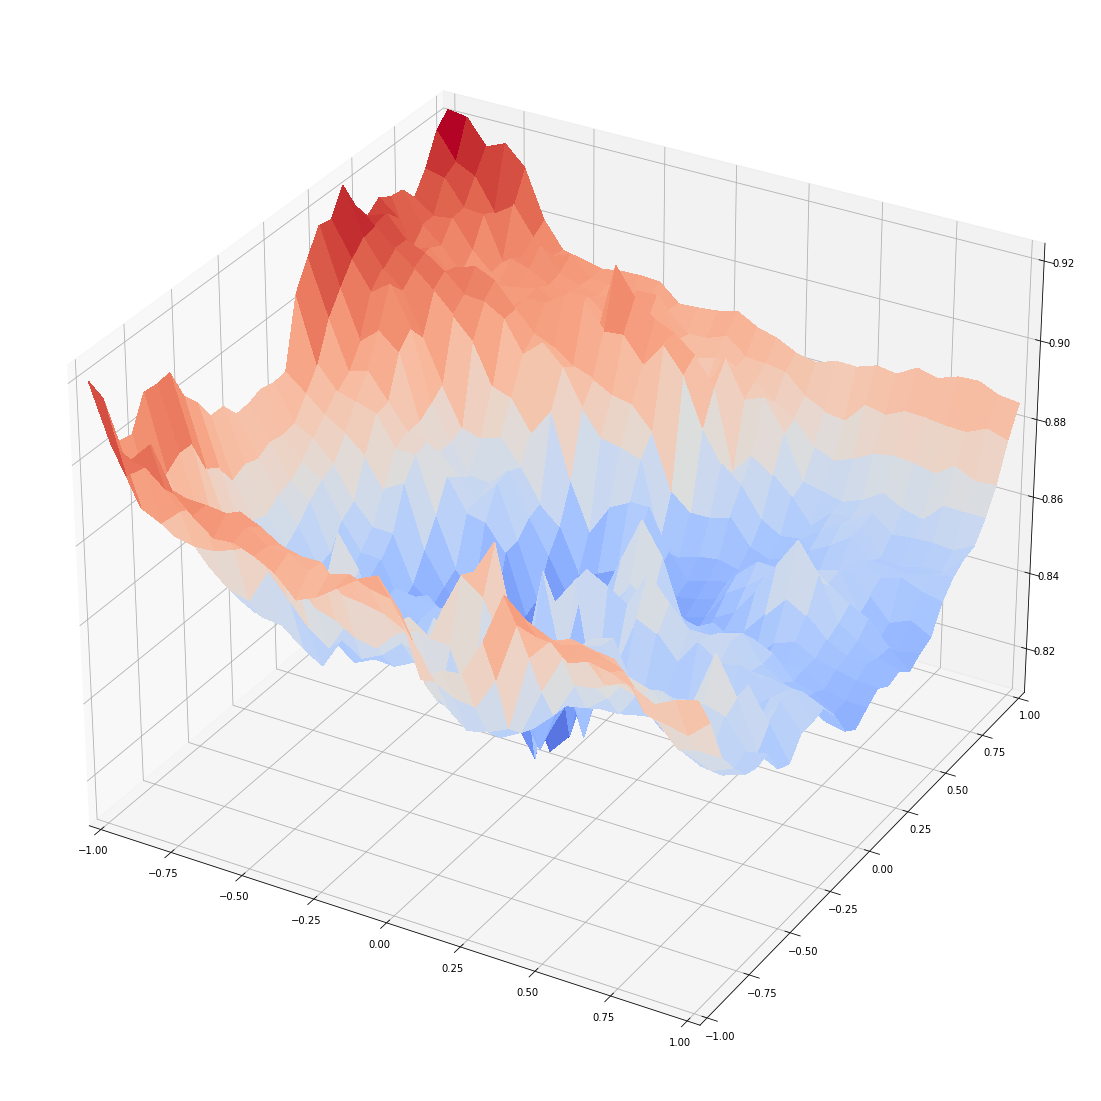

In [ ]:
generate_plots(file_name=PARTIAL_NAME, 
               with_axes=True,
               log=True)

<Figure size 1440x1440 with 0 Axes>

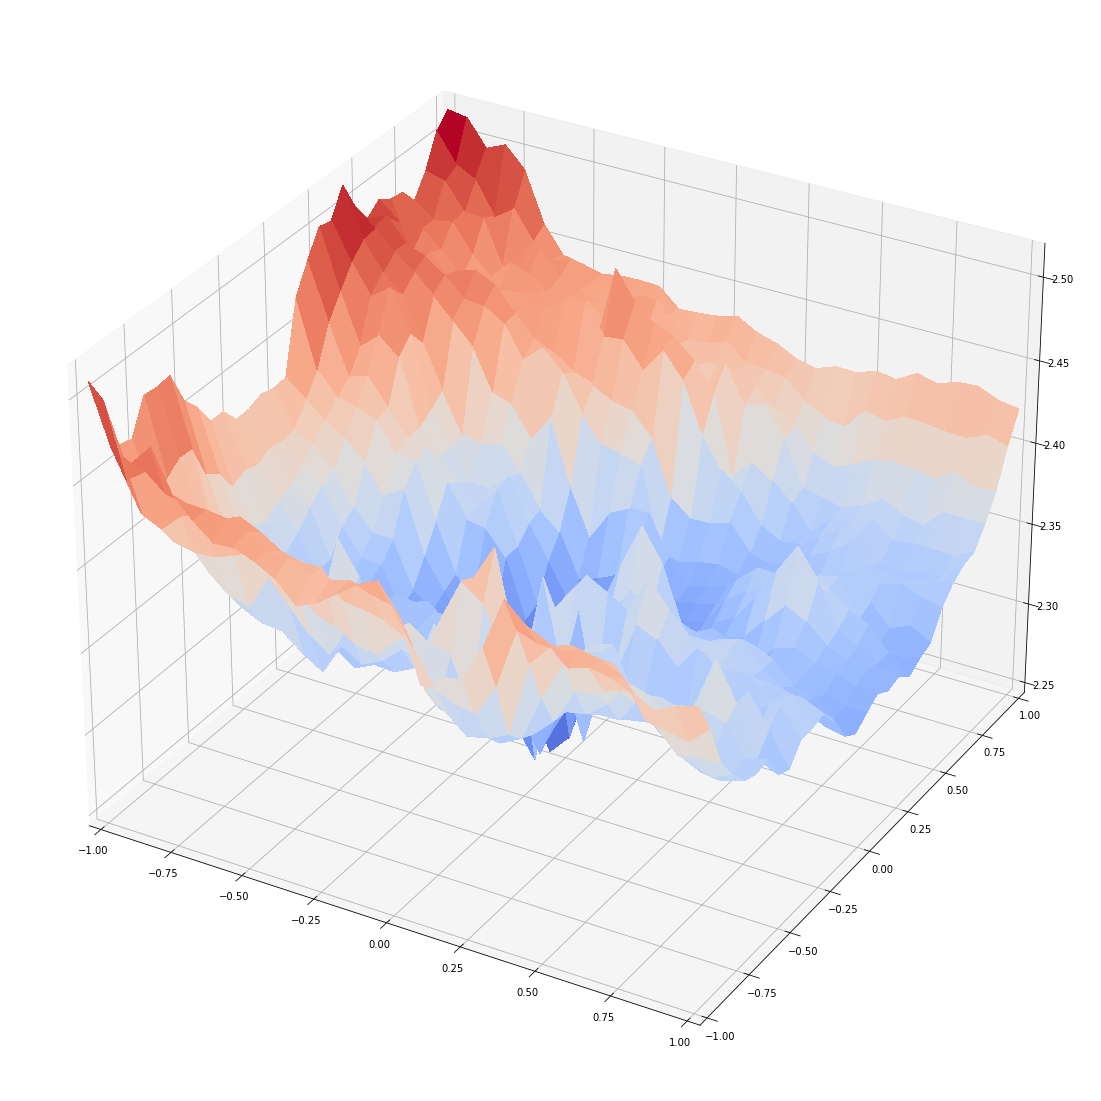

In [ ]:
generate_plots(file_name=PARTIAL_NAME, 
               with_axes=True,
               log=False)